<h1> Exploratory Data Analysis</h1>

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import seaborn as sns
from mlxtend.classifier import StackingClassifier
from tqdm import tqdm
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


<h2>Reading Data</h2>

<h3> Reading Gene and Variation Data</h3>

In [2]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
print(data.head())

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']
   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h3> Reading Text Data</h3>

In [3]:
data_text = pd.read_csv('training_text',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
# note the seprator in this file
#data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
print(data_text.head())

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']
   ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


<h3> Preprocessing of text</h3>

In [4]:
import nltk
nltk.download('stopwords')
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chauh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 139.286755908 seconds


In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [9]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<h3> Test, Train and Cross Validation Split</h3>

<h4> Splitting data into train, test and cross validation (64:20:16)</h4>

In [10]:
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4> Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

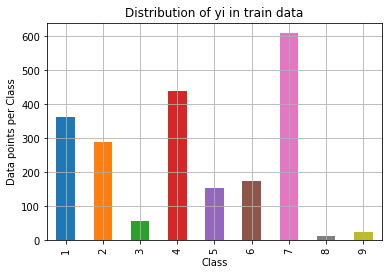

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


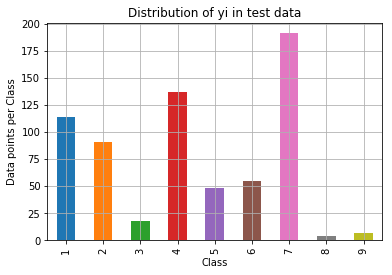

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


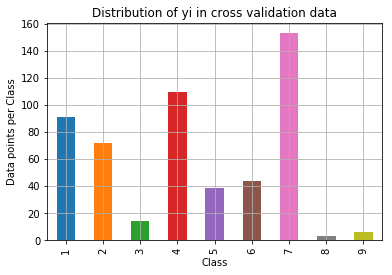

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [12]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


<h2> Prediction using a 'Random' Model</h2>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

In [13]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

Let's build a model just like the earlier!

<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [14]:
#print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
#test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
#cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
#print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
#print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

<h3>3.2.3 Univariate Analysis on Text Feature</h3>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [15]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [16]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [17]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1,4))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 2000


In [18]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [19]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [20]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [21]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({8.107458807062756: 6, 12.161188210594137: 5, 6.175211107676173: 3, 5.964914086653654: 3, 9.639124935988354: 2, 9.554176343079854: 2, 9.234066388210554: 2, 8.531257196250397: 2, 8.241160595845495: 2, 8.065932245539713: 2, 7.677333488930229: 2, 7.116727417348339: 2, 6.753140423951333: 2, 6.670585876702263: 2, 6.244650157223915: 2, 6.205926402775145: 2, 6.201224612487505: 2, 4.961643926327183: 2, 206.84861736111543: 1, 145.39557954682397: 1, 122.7951179508506: 1, 109.50294665722173: 1, 103.73544821541319: 1, 94.00645386517004: 1, 93.4382136620825: 1, 93.2706032644019: 1, 93.1503914272047: 1, 91.55617436746677: 1, 91.321923971628: 1, 89.32793438650664: 1, 79.44198748555718: 1, 73.47275804578197: 1, 73.01333693198573: 1, 71.63546014765099: 1, 65.49670082927048: 1, 65.23706826976925: 1, 64.9831439924159: 1, 64.51825360094682: 1, 64.2287746204613: 1, 63.86644673052713: 1, 61.296112179158506: 1, 57.10729744134412: 1, 56.60273039409775: 1, 56.218632512590254: 1, 55.36312370149036: 1, 5

For values of alpha =  1e-05 The log loss is: 1.0736651926655145
For values of alpha =  0.0001 The log loss is: 1.056821588194288
For values of alpha =  0.001 The log loss is: 1.3660538335235464
For values of alpha =  0.01 The log loss is: 1.7216381044405868
For values of alpha =  0.1 The log loss is: 2.054067543722862
For values of alpha =  1 The log loss is: 2.037065714411701


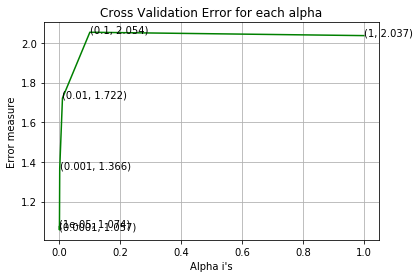

For values of best alpha =  0.0001 The train log loss is: 0.743577164481479
For values of best alpha =  0.0001 The cross validation log loss is: 1.056821588194288
For values of best alpha =  0.0001 The test log loss is: 1.1654739833867578


In [22]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

###### Now let's further try some more EDA

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


##### Let's see how the Gene feature in distributed in train data

In [24]:
frequency_Gene_train = train_df['Gene'].value_counts()
frequency_Gene_train[:5]

BRCA1    179
TP53     109
EGFR      90
BRCA2     79
PTEN      74
Name: Gene, dtype: int64

In [25]:
frequency_Gene_train = dict(frequency_Gene_train)
gene_train = []
freq_train = []
for i in frequency_Gene_train:
  gene_train.append(i)

for i in frequency_Gene_train.values():
  freq_train.append(i)

freq_Gene_train = pd.DataFrame(gene_train, columns=['Gene'])
freq_Gene_train['freq'] = freq_train
freq_Gene_train.head()

,Gene,freq
0,BRCA1,179
1,TP53,109
2,EGFR,90
3,BRCA2,79
4,PTEN,74


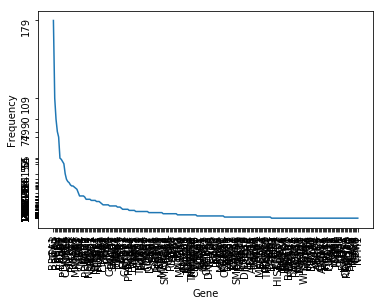

In [26]:
plt.plot(freq_Gene_train.Gene,freq_Gene_train.freq)
plt.xlabel("Gene")
plt.ylabel("Frequency")
plt.xticks(freq_Gene_train.Gene, rotation='vertical')
plt.yticks(freq_Gene_train.freq, rotation='vertical')
plt.show()

##### The above plot shows how there are only a few genes that occur many times and large number of genes do not occurr significant amount of times. Still the plot is not very comprehensive, we will  see the top 20 occuring Genes but first let's take a look at the distribution in the test data

###### So on test data

In [27]:
frequency_Gene_test = test_df['Gene'].value_counts()
frequency_Gene_test[:5]

BRCA1    40
EGFR     31
PTEN     31
TP53     31
BRCA2    28
Name: Gene, dtype: int64

In [28]:
frequency_Gene_test = dict(frequency_Gene_test)
gene_test = []
freq_test = []
for i in frequency_Gene_test:
  gene_test.append(i)

for i in frequency_Gene_test.values():
  freq_test.append(i)

freq_Gene_test = pd.DataFrame(gene_test, columns=['Gene'])
freq_Gene_test['freq'] = freq_test
freq_Gene_test.head()

,Gene,freq
0,BRCA1,40
1,EGFR,31
2,PTEN,31
3,TP53,31
4,BRCA2,28


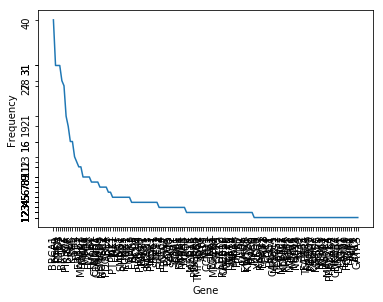

In [29]:
plt.plot(freq_Gene_test.Gene,freq_Gene_test.freq)
plt.xlabel("Gene")
plt.ylabel("Frequency")
plt.xticks(freq_Gene_test.Gene, rotation='vertical')
plt.yticks(freq_Gene_test.freq, rotation='vertical')
plt.show()

##### This is somewhat similar to the one we saw in the train data. But they are large in number so we cannot make out whether the high occuring Genes in the test data are similar to the high occuring genes in the train data. Hence let's reduce the number and check for the top 20 occurences

##### train data

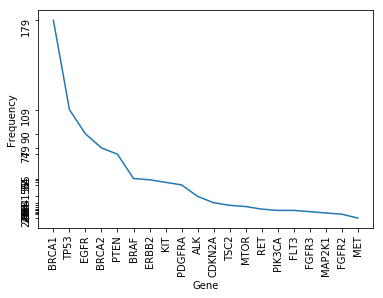

In [30]:
plt.plot(freq_Gene_train.Gene[:20],freq_Gene_train.freq[:20])
plt.xlabel("Gene")
plt.ylabel("Frequency")
plt.xticks(freq_Gene_train.Gene[:20], rotation='vertical')
plt.yticks(freq_Gene_train.freq[:20], rotation='vertical')
plt.show()

##### test data

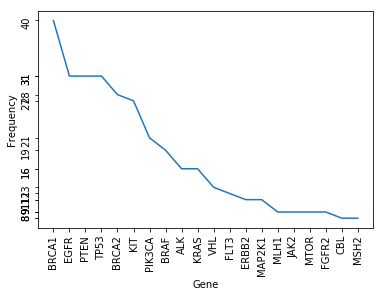

In [31]:
plt.plot(freq_Gene_test.Gene[:20],freq_Gene_test.freq[:20])
plt.xlabel("Gene")
plt.ylabel("Frequency")
plt.xticks(freq_Gene_test.Gene[:20], rotation='vertical')
plt.yticks(freq_Gene_test.freq[:20], rotation='vertical')
plt.show()

##### So yeah, it clearly appears that they come from the same distribution

Let us see only for the top 10 Genes

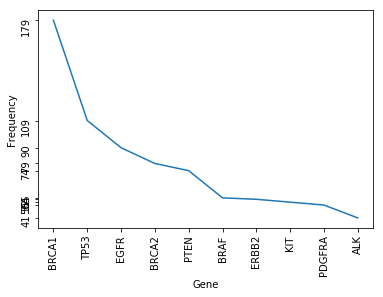

In [32]:
plt.plot(freq_Gene_train.Gene[:10],freq_Gene_train.freq[:10])
plt.xlabel("Gene")
plt.ylabel("Frequency")
plt.xticks(freq_Gene_train.Gene[:10], rotation='vertical')
plt.yticks(freq_Gene_train.freq[:10], rotation='vertical')
plt.show()

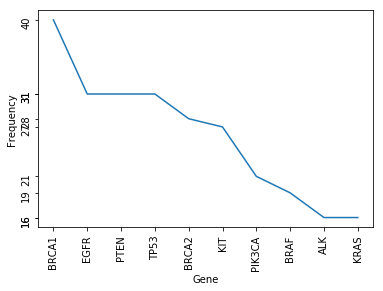

In [33]:
plt.plot(freq_Gene_test.Gene[:10],freq_Gene_test.freq[:10])
plt.xlabel("Gene")
plt.ylabel("Frequency")
plt.xticks(freq_Gene_test.Gene[:10], rotation='vertical')
plt.yticks(freq_Gene_test.freq[:10], rotation='vertical')
plt.show()

##### On looking at the top 10 occurences, we cna clearly see that there are only a few that occur high number of times as the curve in both train and test cases could be seen to dro quite fast.

##### Now let's try to pull off similar analysis on the Variation feature

In [34]:
frequency_Variation_train = train_df['Variation'].value_counts()
frequency_Variation_train[:5]

Truncating_Mutations    56
Amplification           52
Deletion                46
Fusions                 24
Overexpression           6
Name: Variation, dtype: int64

In [35]:
frequency_Variation_train = dict(frequency_Variation_train)
variation_train = [i for i in frequency_Variation_train]
freq_train = [i for i in frequency_Variation_train.values()]

freq_Var_train = pd.DataFrame(variation_train, columns=['Variation'])
freq_Var_train['freq'] = freq_train
freq_Var_train.head()

,Variation,freq
0,Truncating_Mutations,56
1,Amplification,52
2,Deletion,46
3,Fusions,24
4,Overexpression,6


In [36]:
freq_Var_train.shape

(1926, 2)

##### Let's directly see for the top 20 occurences. For both train and the test data sets.

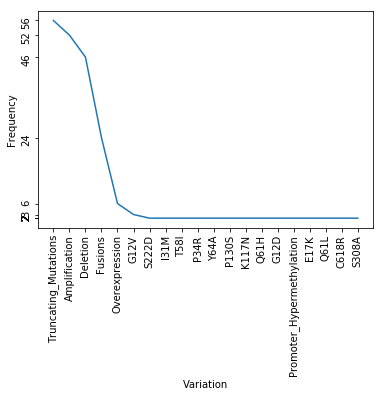

In [37]:
plt.plot(freq_Var_train.Variation[:20],freq_Var_train.freq[:20])
plt.xlabel("Variation")
plt.ylabel("Frequency")
plt.xticks(freq_Var_train.Variation[:20], rotation='vertical')
plt.yticks(freq_Var_train.freq[:20], rotation='vertical')
plt.show()

In [38]:
frequency_Variation_test = test_df['Variation'].value_counts()
frequency_Variation_test[:5]

Truncating_Mutations    20
Deletion                12
Amplification            9
Fusions                  7
Q61R                     3
Name: Variation, dtype: int64

In [39]:
frequency_Variation_test = dict(frequency_Variation_test)
variation_test = [i for i in frequency_Variation_test]
freq_test = [i for i in frequency_Variation_test.values()]

freq_Var_test = pd.DataFrame(variation_test, columns=['Variation'])
freq_Var_test['freq'] = freq_test
freq_Var_test.head()

,Variation,freq
0,Truncating_Mutations,20
1,Deletion,12
2,Amplification,9
3,Fusions,7
4,Q61R,3


In [40]:
freq_Var_test.shape

(614, 2)

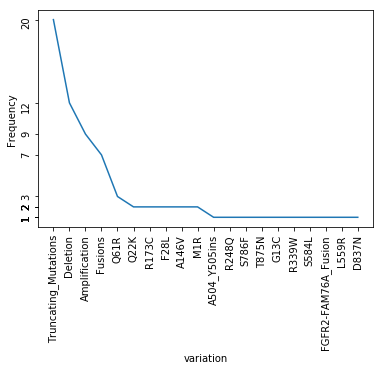

In [41]:
plt.plot(freq_Var_test.Variation[:20],freq_Var_test.freq[:20])
plt.xlabel("variation")
plt.ylabel("Frequency")
plt.xticks(freq_Var_test.Variation[:20], rotation='vertical')
plt.yticks(freq_Var_test.freq[:20], rotation='vertical')
plt.show()

##### We again see the similar steep decrease in the frequencies as again for the Variation feature also, there are only a few with higher freq and most of them only occur once.

##### Now let' see if we can make anything more out of the text feature

Distribution of the lengths of text in train data and text data.

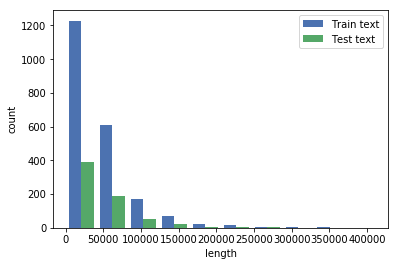

In [42]:
length_text_train = [len(l) for l in train_df['TEXT'].values]
length_text_test = [len(l) for l in test_df['TEXT'].values]

plt.style.use('seaborn-deep')

plt.hist([length_text_train, length_text_test], label=['Train text', 'Test text'])
plt.legend(loc='upper right')
plt.xlabel('length')
plt.ylabel('count')
plt.show()
#print(length_text_train)

##### Let's have a better view of the distribution of the lengths of the texts in train and test text together.

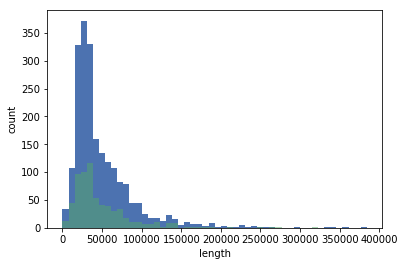

In [43]:
age = np.random.normal(loc=1, size=100) # a normal distribution
salaray = np.random.normal(loc=-1, size=10000) # a normal distribution
 
_, bins, _ = plt.hist(length_text_train, bins=50)
_ = plt.hist(length_text_test, bins=bins, alpha=0.5)
plt.xlabel('length')
plt.ylabel('count')
plt.show()

##### Let's see the more important and frequently occuring words in the Text available in both train and test data

In [45]:
train_text = []
for sent in tqdm(train_df['TEXT'].values):
    for word in sent.split(" "):
        train_text.append(word)
    
test_text = []
for sent in tqdm(test_df['TEXT'].values):
    for word in sent.split():
        test_text.append(word)

100%|███████████████████████████████████████████████████████████████████████████████| 665/665 [00:00<00:00, 869.30it/s]


In [46]:
train_text = set(train_text)

tra_text = ''
for i in train_text:
    tra_text += i
    tra_text += ' '
    
test_text = set(test_text)

tes_text = ''
for i in test_text:
    tes_text += i
    tes_text += ' '

##### Plotting word clouds for both train and test data

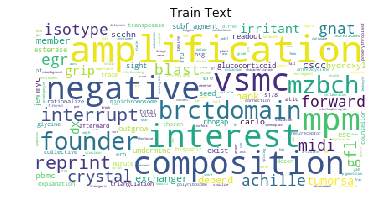

In [47]:
from wordcloud import WordCloud, STOPWORDS

wordcloud_train = WordCloud(background_color='white', stopwords=set(STOPWORDS)).generate(tra_text)
plt.imshow(wordcloud_train)
plt.title('Train Text')
plt.axis('off')
plt.show()

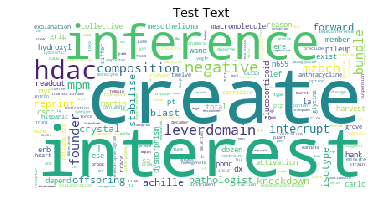

In [48]:
wordcloud_test = WordCloud(background_color='white', stopwords=set(STOPWORDS)).generate(tes_text)
plt.imshow(wordcloud_test)
plt.title('Test Text')
plt.axis('off')
plt.show()